### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# MiDaS

*Author: Intel ISL*

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy. The models have been trained on 10 distinct datasets using
multi-objective optimization to ensure high quality on a wide range of inputs.

### Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models). Install with

In [1]:
# pip install timm

### Example Usage

Download an image from the PyTorch homepage

In [2]:
import cv2
import torch
# import urllib.request

import matplotlib.pyplot as plt

# url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
# urllib.request.urlretrieve(url, filename)
filename = "IMG_2134.jpeg"

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [3]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /Users/pranavpabba/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/pranavpabba/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Move model to GPU if available

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
midas.to(device)
midas.eval()

cpu


MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

Load transforms to resize and normalize the image for large or small model

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /Users/pranavpabba/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

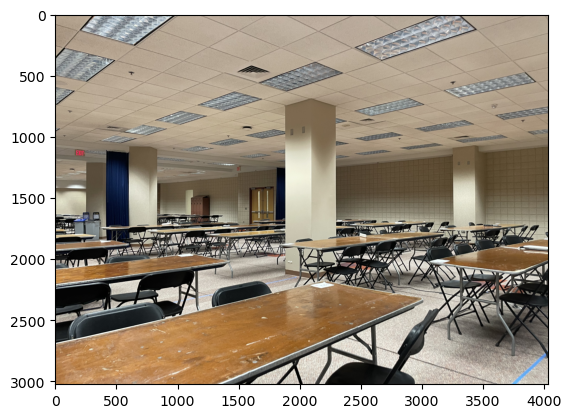

In [6]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


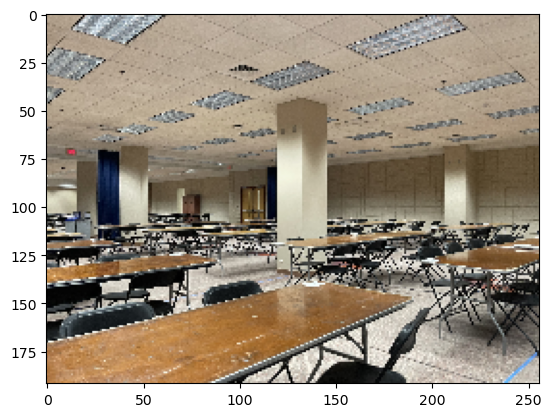

In [7]:
# Compress the image using original proportions of image (get the height and width of the image)
height, width, _ = img.shape
# Resize the image to 256 x 256/height * width
img = cv2.resize(img, (256, int(256 * height / width)))
plt.imshow(img)
input_batch = transform(img).to(device)

Predict and resize to original resolution

In [8]:
import time

with torch.no_grad():
    start_time = time.time()
    prediction = midas(input_batch)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.4f} seconds")

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Execution time: 0.2818 seconds


Show result

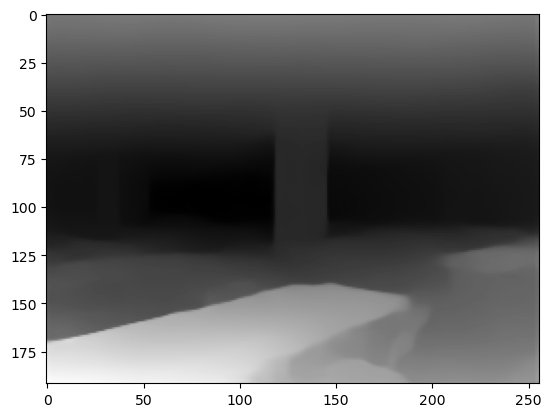

In [9]:
plt.imshow(output, cmap='gray')
# plt.show()

### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

[Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413)

Please cite our papers if you use our models: